In [2]:
# ───────────────────────────────────────────────────────────────
#  Bootstrap: add project root AND ensure src/ is a package
# ───────────────────────────────────────────────────────────────
import os, sys, pkgutil
from pathlib import Path

# 1) paths
current_dir  = Path.cwd()           # /…/hpo_inference/hpo_inference/notebooks
project_root = current_dir.parents[0]   # /…/hpo_inference
src_dir      = project_root / "src"
utils_dir    = src_dir / "utils"
data_dir      = project_root / "data"


# 2) make sure __init__.py files exist
for d in (src_dir, utils_dir):
    d.mkdir(parents=True, exist_ok=True)
    init_file = d / "__init__.py"
    if not init_file.exists():
        init_file.touch()           # empty file is fine

# 3) add to sys.path once
project_root_str = str(project_root)
if project_root_str not in sys.path:
    sys.path.insert(0, project_root_str)

print("✅ Current dir :", current_dir)
print("✅ Project root in PYTHONPATH :", project_root_str)
print("✅ src package found? ->", pkgutil.find_loader("src") is not None)

# 4) now the project‑specific imports
from src.utils.po_fun           import BasicUtils, StatisticalUtils, GenerationUtils
from src.utils.po_fun_plot      import PO_plot
from src.utils.po_accelerator_nle import LogLikelihoodCache, HPO_LogLikelihoodCache
from src.mcmc.hpo_po_hm_mcmc_k  import mcmc_simulation_hpo_k
from src.mcmc.hpo_po_hm_mcmc    import mcmc_simulation_hpo


# 3) Standard libraries
import math
import random
import itertools
from collections import Counter, defaultdict
from typing import List, Dict, Any, Optional

# 4) Third‑party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import math, random, itertools, threading, multiprocessing as mp
from scipy.stats import multivariate_normal, norm, beta

# 5) load config
import yaml, pprint
config_path = project_root / "config" / "hpo_mcmc_configuration.yaml"
with open(config_path) as f:
    config = yaml.safe_load(f)

print("✅ Configuration loaded, top‑level keys:", list(config.keys())[:10])


data_path   = project_root  / "data"   / "item_characteristics.csv"

import threading
import itertools
import numpy as np
import multiprocessing
from typing import List, Dict, Any
from multiprocessing import Manager

✅ Current dir : /home/doli/Desktop/research/coding/hpo_inference/notebooks
✅ Project root in PYTHONPATH : /home/doli/Desktop/research/coding/hpo_inference
✅ src package found? -> True
✅ Configuration loaded, top‑level keys: ['sampling', 'mcmc', 'reversible_two_factors', 'rho', 'rhotau', 'beta', 'noise', 'prior']


Number of distinct items in the HPO data: n = 10
Assessors in the HPO data: assessors = [1, 2, 3, 4, 5]
[[ 0.37802569  0.48863089 -0.15577621 -0.44536924 -1.8669192   0.55245804
   0.94064396  0.65468969  1.10033821 -0.23004837]
 [-1.01646298  0.47438509  0.01097829 -0.52150505 -0.40398393  0.47443509
  -0.09434498 -0.72379677  1.37025631  0.81945642]
 [ 0.14047358  2.25298144 -1.63119938  1.02517382  0.05745798  1.12308145
  -1.2792336  -0.93658146  0.90782351  1.72752573]
 [-0.13616264  0.47518221  0.68298665 -1.50720735  0.74654455  1.0137161
  -0.47655306  1.39967845 -0.0467856  -0.46253666]
 [-1.01137608  0.52092759 -0.29971271  1.59843582  0.61110338 -0.09988741
  -0.2526811  -0.55978434 -0.0802858   1.06393059]]
prob niose is:
0.04027776467101665
Tau true is: 
0.54275186514501
K true is: 
3

 The covariates effects (alpha):
[ 3.12287534  0.7768854  -0.05587726 -3.36024232 -0.59573663  1.66610571
 -0.5304941   2.6580207  -0.29584016 -2.13670925]
The global partial order matrix is

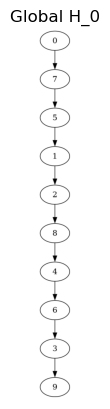

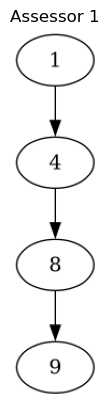

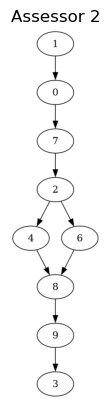

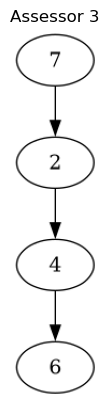

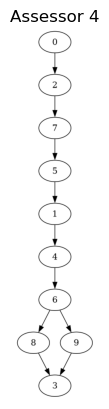

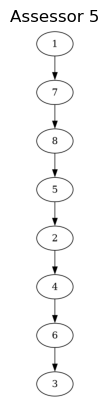

In [3]:
data_file = data_dir / "item_characteristics.csv"
# Read the items section (first part of the CSV)
items_df = pd.read_csv(data_file, nrows=10)
# Count distinct item IDs
n = len(items_df['item_id'].unique())
print(f"Number of distinct items in the HPO data: n = {n}")
# Read the assessors section (skip items and blank line)
assessors_df = pd.read_csv(data_file, skiprows=12, nrows=5)
assessors = assessors_df['assessor_id'].tolist()
print(f"Assessors in the HPO data: assessors = {assessors}")
# read the covariates 
covariate_cols = [col for col in items_df.columns if col.startswith('covariate_')]
X_values = items_df[covariate_cols].values

X = X_values.T  # Features in rows, items in columns

print(X)
p = X.shape[0]
# First let's give a U0 , to sample U0 we need the rho, and the number of nodes
#K_prior=config["prior"]["k_prior"]
rho_prior = config["prior"]["rho_prior"]
noise_option = config["noise"]["noise_option"]
sigma_beta = config["prior"]["sigma_beta"]  # Standard deviation of the normal distribution for beta
rng = np.random.default_rng(42)
beta_true =rng.normal(loc=0.0, scale=sigma_beta, size=(p,))
tau_true = StatisticalUtils.rTauprior() 
rho_true=beta.rvs(1,rho_prior)
#K=StatisticalUtils.rKprior(K_prior) 
K=config["mcmc"]["K"]
K_true=K

noise_beta_prior = config["prior"]["noise_beta_prior"] 
prob_noise_true = StatisticalUtils.rPprior(noise_beta_prior)
print("prob niose is:")
print(prob_noise_true)


print("Tau true is: ") 
print(tau_true)
print("K true is: ")
print(K_true)

alpha = X.T @ beta_true  
print("\n The covariates effects (alpha):")
print(alpha)

#now we generate the subset 

# Generate selection lists Ma for each order
items = list(range(n))
item_to_index = {item: idx for idx, item in enumerate(items)}
index_to_item = {idx: item for idx, item in enumerate(items)}
M_a_list= GenerationUtils.generate_subsets(len(assessors), n) 
# We further sort the subsets 
M_a_dict = {a: sorted(subset) for a, subset in zip(assessors, M_a_list)}

##Generate U_0 
U_global = GenerationUtils.generate_U(n, K_true, rho_true)


## Construct the Ua_dict: 
U_a_dict = {}  # We'll store U^(a) in a dictionary keyed by assessor ID

index_to_item_local_dict = {
    a: {i: item for i, item in enumerate(M_a_dict[a])}
    for a in assessors
}

for idx_a, a in enumerate(assessors):
    Ma = M_a_list[idx_a]
    n_a = len(Ma)
    Ua = np.zeros((n_a, K), dtype=float)

    # For each item j in M_a, sample from N(tau_true * U_global[j], (1 - tau_true^2)*I)
    for i_loc, j_global in enumerate(Ma):        
        mean_vec = tau_true * U_global[j_global, :]
        Sigma=BasicUtils.build_Sigma_rho(K, rho_true)
        cov_mat = (1.0 - tau_true**2) * Sigma
        Ua[i_loc, :] = np.random.multivariate_normal(mean=mean_vec, cov=cov_mat)

    U_a_dict[a] = Ua

# Transform the U to H given the partial order definition
h_U_dict = StatisticalUtils.build_hierarchical_partial_orders(
    M0=items,
    assessors=assessors,
    M_a_dict=M_a_dict, 
    U0=U_global,
    U_a_dict=U_a_dict,
    alpha=alpha,
    link_inv=None
)
## Visualise the partial order matrix
for i in range(0,len(assessors)):
    if i==0:
        print(f"The global partial order matrix is:")
        print(BasicUtils.transitive_reduction(h_U_dict[0]))
        PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_U_dict[0]), items ,f"Global H_0")

    print(f"Assessor {assessors[i]} has partial order matrix:")
    print(M_a_dict.get(assessors[i]))
    print(BasicUtils.transitive_reduction(h_U_dict.get(assessors[i])))
    PO_plot.visualize_partial_order(BasicUtils.transitive_reduction(h_U_dict.get(assessors[i])), M_a_dict.get(assessors[i]), f"Assessor {assessors[i]}")


# Generate choice sets for each assessor from its Ma list:
min_tasks=config["sampling"]["min_tasks_scaler"]*n
min_size=config["sampling"]["min_size"]
O_a_i_dict = GenerationUtils.generate_choice_sets_for_assessors(M_a_dict, min_tasks=min_tasks, min_size= min_size)

# Print the result
for assessor, tasks in O_a_i_dict.items():
    print(f"Assessor {assessor}: {tasks}")


y_a_i_dict = GenerationUtils.generate_total_orders_for_assessor(h_U_dict, M_a_dict,O_a_i_dict,prob_noise_true)

PO_plot.save_rankings_to_csv(y_a_i_dict, output_file='data/observed_rankings_no_multiple.csv')


In [4]:
with open(config_path) as f:
    CFG = yaml.safe_load(f)
# ──────────────────── Data ingest (demo) ──────────────────────────
items_df      = pd.read_csv(data_path, nrows=10)
assessors_df  = pd.read_csv(data_path, skiprows=12, nrows=5)

items      = sorted(items_df["item_id"].unique().tolist())
assessors  = assessors_df["assessor_id"].tolist()
X          = items_df[[c for c in items_df if c.startswith("covariate_")]].to_numpy().T
p          = X.shape[0]

# build synthetic “true” parameters & simulated observations
rng         = np.random.default_rng(42)
sigma_beta  = CFG["prior"]["sigma_beta"]
beta_true   = rng.normal(0.0, sigma_beta, size=p)
alpha       = X.T @ beta_true

K           = CFG["mcmc"]["K"]
rho_true    = np.random.beta(1, CFG["prior"]["rho_prior"])
tau_true    = StatisticalUtils.rTauprior()
prob_noise_true = StatisticalUtils.rPprior(CFG["prior"]["noise_beta_prior"])

M_a_dict    = {a: s for a, s in zip(assessors,
                 GenerationUtils.generate_subsets(len(assessors), len(items)))}

U0_true     = GenerationUtils.generate_U(len(items), K, rho_true)
U_a_dict    = GenerationUtils.generate_U_a_dict(M_a_dict, U0_true, tau_true, rho_true)

h_U_dict    = StatisticalUtils.build_hierarchical_partial_orders(
                M0=items, assessors=assessors, M_a_dict=M_a_dict,
                U0=U0_true, U_a_dict=U_a_dict, alpha=alpha)

O_a_i_dict  = GenerationUtils.generate_choice_sets_for_assessors(
                M_a_dict,
                min_tasks=int(CFG["sampling"]["min_tasks_scaler"]*len(items)),
                min_size =CFG["sampling"]["min_size"])

y_a_i_dict  = GenerationUtils.generate_total_orders_for_assessor(
                h_U_dict, M_a_dict, O_a_i_dict, prob_noise_true)

# ──────────────────── Helper to build per-chain cfg ───────────────
def build_chain_cfg(seed: int) -> Dict[str, Any]:
    return dict(
        num_iterations = CFG["mcmc"]["num_iterations"],
        mcmc_pt        = [
            CFG["mcmc"]["update_probabilities"]["rho"],
            CFG["mcmc"]["update_probabilities"]["tau"],
            CFG["mcmc"]["update_probabilities"]["rho_tau"],
            CFG["mcmc"]["update_probabilities"]["noise"],
            CFG["mcmc"]["update_probabilities"]["U_0"],
            CFG["mcmc"]["update_probabilities"]["U_a"],
            CFG["mcmc"]["update_probabilities"]["beta"],
        ],
        rho_prior        = CFG["prior"]["rho_prior"],
        noise_beta_prior = CFG["prior"]["noise_beta_prior"],
        mallow_ua        = CFG["prior"]["mallow_ua"],
        dr               = CFG["rho"]["dr"],
        drrt             = CFG["rhotau"]["drrt"],
        drbeta           = CFG["beta"]["drbeta"],
        sigma_mallow     = CFG["noise"]["sigma_mallow"],
        noise_option     = CFG["noise"]["noise_option"],
        sigma_beta       = CFG["prior"]["sigma_beta"],
        random_seed      = seed,
    )

# ──────────────────── Worker: runs one chain ──────────────────────
def run_chain(chain_id: int,
              chain_cfg: Dict[str, Any],
              prog_q: "mp.Queue"):

    res = mcmc_simulation_hpo(
        num_iterations     = chain_cfg["num_iterations"],
        M0                 = items,
        assessors          = assessors,
        M_a_dict           = M_a_dict,
        O_a_i_dict         = O_a_i_dict,
        observed_orders    = y_a_i_dict,
        sigma_beta         = chain_cfg["sigma_beta"],
        X                  = X,
        K                  = K,
        dr                 = chain_cfg["dr"],
        drrt               = chain_cfg["drrt"],
        drbeta             = chain_cfg["drbeta"],
        sigma_mallow       = chain_cfg["sigma_mallow"],
        noise_option       = chain_cfg["noise_option"],
        mcmc_pt            = chain_cfg["mcmc_pt"],
        rho_prior          = chain_cfg["rho_prior"],
        noise_beta_prior   = chain_cfg["noise_beta_prior"],
        mallow_ua          = chain_cfg["mallow_ua"],
        rho_tau_update     = CFG["reversible_two_factors"]["rho_tau_update"],
        random_seed        = chain_cfg["random_seed"]
    )

    prog_q.put((chain_id, "done"))
    return chain_id, res

# ──────────────────── Progress-monitor thread ─────────────────────
def monitor(q: "mp.Queue", n: int):
    seen = 0
    while seen < n:
        cid, msg = q.get()
        seen += 1
        print(f"[Progress] chain {cid} → {msg}")
    print("[Progress] all chains reported.\n")

# ──────────────────── Main (multiprocessing safe) ─────────────────
def main():
    num_chains = 3

    manager   = mp.Manager()
    prog_q    = manager.Queue()

    thread    = threading.Thread(target=monitor, args=(prog_q, num_chains), daemon=True)
    thread.start()

    with mp.Pool(processes=num_chains) as pool:
        async_results = [
            pool.apply_async(run_chain,
                             args=(cid, build_chain_cfg(seed=100+cid), prog_q))
            for cid in range(num_chains)
        ]
        results = sorted((ar.get() for ar in async_results), key=lambda x: x[0])

    thread.join()

    for cid, out in results:
        steps = len(out["log_likelihood_currents"])
        print(f"Chain {cid}: {steps} steps, final accept rate = {out['acceptance_rates'][-1]:.3f}")

    total = sum(len(o["log_likelihood_currents"]) for _, o in results)
    print(f"\nCombined = {total} MCMC iterations across {num_chains} chains.")

# ──────────────────── guard ───────────────────────────────────────
if __name__ == "__main__":
    mp.freeze_support()      # does nothing on *nix, required on Windows
    main()


ModuleNotFoundError: No module named 'src.utils.po_fun'